# Semi Supervised Learning Tutorial of Gianni Franchi
- GUIMARÃES Eduardo
- LACERDA Filipe
- FRULANE Daniel

Welcome to your ML project!
**In this notebook, you will**:
- Learn what is SSL
- Learn the difficulty with Overfitting
- Learn to implement an Convolutional Neural Network.
- Learn to train it when we don't have enough data

If you have never used jupyter notebooks, nor Colab notebooks, [here](https://colab.research.google.com/notebooks/welcome.ipynb) is a short intro.

In [ ]:
import copy
from numpy import asarray
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision.models as models
from torchvision import transforms
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
import random
import math
from torch.autograd import Variable
#import matplotlib.pyplot as plt
#from modules import *
#import torchvision.models as models_pytorch
#import h5py
#import torch.optim as optim
#import augmentations
from torch.nn.functional import kl_div, softmax, log_softmax
import torch.optim as optim
import torch.utils.data as data
from os.path import exists, join, split
from os import listdir
from os.path import join
from PIL import Image, ImageFilter , ImageDraw
import PIL
import random
#import madgrad
import matplotlib.pyplot as plt
#! pip install madgrad
#! pip install efficientnet_pytorch

In [ ]:
num_class = 10 #number of classes

seed=111 #seed for the algorithm
batch_size = 32
num_train =100 # number of training image by classe
cutout=16  # parameter for the cutout
num_epochs=150
#Validation set size
valid_size = 200
lr=0.1

# First let us define a CNN

In [ ]:
bn_momentum = 0.9


def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)
#regular 3x3 covnet, with and padding of 1 to return the image's initial size

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform_(m.weight, gain=np.sqrt(2))
        init.constant_(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)
#this seems to make differente things if 'm' is training or not

class WideBasic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(WideBasic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes, momentum=bn_momentum)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes, momentum=bn_momentum)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out
#also another regular CNN net, but with a dropout and batchnorms to reduce overfitting, i think
#sequential is literally a batch of modules

class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate, num_classes):
        super(WideResNet, self).__init__()
        self.in_planes = 16

        assert ((depth - 4) % 6 == 0), 'Wide-resnet depth should be 6n+4'
        n = int((depth - 4) / 6)
        k = widen_factor

        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3, nStages[0])
        self.layer1 = self._wide_layer(WideBasic, nStages[1], n, dropout_rate, stride=1)
        self.layer2 = self._wide_layer(WideBasic, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(WideBasic, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=bn_momentum)
        self.linear = nn.Linear(nStages[3], num_classes)

        # self.apply(conv_init)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):#here we seem to see where the magic happens
        #it seems to me that wide layer is a 'batch' of  a number num_blocks of 'block', that transform that data from its initial
        #channel number to 'planes' channels
        strides = [stride] + [1]*(num_blocks-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        # out = F.avg_pool2d(out, 8)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

# now let us define a dataset


In [ ]:
class Dataset_sub_CIFAR(data.Dataset):

    def __init__(self, data_feature, data_target,transform,phase='label'):
        self.data_feature = data_feature
        self.data_target = data_target
        self.transform = transform
        self.phase=phase

    def __len__(self):
        return len(self.data_feature)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        if self.phase=='label':
            data_feature = self.transform(Image.fromarray(np.uint8(self.data_feature[index])))
            data_target =  self.data_target[index]
            return data_feature, data_target

        else:
            data_feature = self.data_feature[index].float()
            return data_feature


class CutoutDefault(object):
    """
    Reference : https://github.com/quark0/darts/blob/master/cnn/utils.py
    """
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        if self.length <= 0:
            return img
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode = 'reflect'),
    #transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
    CutoutDefault(cutout),
])

transform_test = transforms.Compose([
    #transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])



#Dataset loading
CIFAR10_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=None, download=True)
CIFAR10_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=None, download=True)
np.random.seed(seed=seed)
permuation=np.random.permutation(len(CIFAR10_train_dataset.targets))

Original_train_data_x = (CIFAR10_train_dataset.data)
Original_train_data_y = np.array(CIFAR10_train_dataset.targets)
Original_train_data_x = Original_train_data_x[permuation]
Original_train_data_y = Original_train_data_y[permuation]
#permutation of the dataset
Original_test_data_x = CIFAR10_test_dataset.data
Original_test_data_y = np.array(CIFAR10_test_dataset.targets)


#Selection of 250 labeled images for training and 2000 for validation
incr_class = torch.zeros(num_class)
train_idx_dico = {} #labeled images index dictionnary

for i in range(num_class):
    train_idx_dico[str(i)] = []

valid_idx = np.zeros(num_class * valid_size, dtype=np.int32) #validation images indexes (2000)
incr_t = 0
incr_v = 0
incrtotal = 0

for idx in range(len(Original_train_data_y)):
    class_y = Original_train_data_y[idx]
    incrtotal += 1

    train_idx_dico[str(class_y)].append(idx)
    incr_class[class_y] += 1 #count the number of image per class
    incr_t += 1


train_idx = np.zeros(num_class * num_train, dtype=np.int32) #train labeled images indexes (1000)
list_train_id = []
list_unalabel_id = []
valid_idx = []
unlabel_idx_dico = {}
for i in range(num_class):
    unlabel_idx_dico[str(i)] = []
for i in range(num_class):
    list_train_id = list_train_id + train_idx_dico[str(i)][0:num_train]
    valid_idx =valid_idx + train_idx_dico[str(i)][num_train:num_train+valid_size]
    list_unalabel_id = list_unalabel_id + train_idx_dico[str(i)][num_train+valid_size::]
    unlabel_idx_dico[str(i)] = train_idx_dico[str(i)][num_train::]

#Get labeled and unlabeled data

x_train = Original_train_data_x[[int(i) for i in list_train_id]]
y_train = Original_train_data_y[[int(i) for i in list_train_id]]

x_unlabeled = Original_train_data_x[[int(i) for i in list_unalabel_id]]
y_unlabeled = Original_train_data_y[[int(i) for i in list_unalabel_id]]

#Get validation set data
x_valid = Original_train_data_x[[int(i) for i in valid_idx]]
y_valid = Original_train_data_y[[int(i) for i in valid_idx]]

# Printing the size of the training, validation and test sets
print('Number of training examples: ' + str(x_train.shape[0]))
print('Number of unlabeled examples: ' + str(x_unlabeled.shape[0]))
print('Number of validation examples: ' + str(x_valid.shape[0]))



classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#Dataloader creation

test_loader = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(Original_test_data_x, Original_test_data_y, transform=transform_test),
    batch_size = batch_size,
    shuffle=False, num_workers=2)

train_loader = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(x_train, y_train, transform=transform_train),
    batch_size=batch_size,shuffle=True, num_workers=2) #num_workers = 2 ou 1

valid_loader = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(x_valid, y_valid, transform=transform_test),
    batch_size=batch_size,
    shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:13<00:00, 13065443.68it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Number of training examples: 1000
Number of unlabeled examples: 47000
Number of validation examples: 2000


# Now we build the CNN and the optimizer

We can make some plots to find optimal values for the dropout rate:

In [ ]:
criterion = nn.CrossEntropyLoss()
#Networks creation
net = WideResNet(28, 2, dropout_rate=0.0, num_classes=num_class)
net =net.cuda()
net_save = WideResNet(28, 2, dropout_rate=0.0, num_classes=num_class) # model where to save the results
net_save =net_save.cuda()

def learning_rate_scheduler(init, epoch): #correct the learning rate after achieving an error plateau
    optim_factor = 0
    if(epoch > 200):
        optim_factor = 3
    elif(epoch > 160):
        optim_factor = 2
    elif(epoch > 50):
        optim_factor = 1

    return init*math.pow(0.1, optim_factor)


# Training
def train(epoch,net,trainloader,log_interval=15):
    net.train()
    train_loss = 0
    correct = 0
    counter=0
    total = 0
    print('\n=> Training Epoch #%d, LR=%.4f' %(epoch, learning_rate_scheduler(lr, epoch)))
    optimizer = optim.SGD(net.parameters(), lr=learning_rate_scheduler(lr, epoch), momentum=0.9, weight_decay=5e-4)
    for batch_idx, (inputs, targets) in enumerate(trainloader):

        inputs, targets = inputs.cuda(), targets.cuda() # GPU settings
        optimizer.zero_grad()
        #inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)               # Forward Propagation
        loss = criterion(outputs, targets)  # Loss
        loss.backward()  # Backward Propagation
        optimizer.step() # Optimizer update

        train_loss += loss.item()
        counter+=1
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        if batch_idx % log_interval == 0:
            print('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, num_epochs, batch_idx+1,
                    (len(trainloader.dataset)//batch_size)+1, loss.item(), 100.*correct/total))
    return train_loss/counter, 100.*correct/total

def test(epoch,net,testloader):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    counter = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            counter+=1
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()


    acc = 100.*correct/total
    print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), acc))
    return acc,test_loss/counter

# Training



In [ ]:
best_acc=0
import pandas as pd
dropout_rates= np.linspace(0,0.5,5) # our list of possible dropout rates
losses_droprate=[]
acc_droprate=[]

def test_final(net,testloader):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()
            if batch_idx == 0:
                predicted_concat = predicted.clone()
            else:
                predicted_concat = torch.cat((predicted_concat, predicted), 0)

        # Save checkpoint when best model
    acc = 100.*correct/total
    print("\n| TEST \t\t\tLoss: %.4f Acc@1: %.2f%%" %( loss.item(), acc))

    return predicted_concat.cpu().numpy(),acc,loss.item()

# for epoch in range(num_epochs):


#     train(epoch,net,train_loader)
#     acc =test(epoch,net,valid_loader)
#     # Save checkpoint when best model
#     if acc > best_acc:
#         print('| Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
#         net_save.load_state_dict(net.state_dict(), strict=True)
#         best_acc=acc

# Q0 = finding hyperparameters and Evaluation

What we'll do from here on out is to discover the optimal value for our dropout rate:



=> Training Epoch #0, LR=0.1000
| Epoch [  0/ 50] Iter[  1/ 32]		Loss: 2.3026 Acc@1: 18.750%
| Epoch [  0/ 50] Iter[ 16/ 32]		Loss: 2.3616 Acc@1: 14.844%
| Epoch [  0/ 50] Iter[ 31/ 32]		Loss: 2.2104 Acc@1: 16.935%

| Validation Epoch #0			Loss: 5.5577 Acc@1: 14.35%

=> Training Epoch #1, LR=0.1000
| Epoch [  1/ 50] Iter[  1/ 32]		Loss: 2.3906 Acc@1: 18.750%
| Epoch [  1/ 50] Iter[ 16/ 32]		Loss: 2.1857 Acc@1: 20.117%
| Epoch [  1/ 50] Iter[ 31/ 32]		Loss: 1.9354 Acc@1: 19.556%

| Validation Epoch #1			Loss: 1.7840 Acc@1: 16.80%

=> Training Epoch #2, LR=0.1000
| Epoch [  2/ 50] Iter[  1/ 32]		Loss: 2.0646 Acc@1: 21.875%
| Epoch [  2/ 50] Iter[ 16/ 32]		Loss: 2.4192 Acc@1: 25.195%
| Epoch [  2/ 50] Iter[ 31/ 32]		Loss: 2.0213 Acc@1: 24.597%

| Validation Epoch #2			Loss: 1.5477 Acc@1: 18.35%

=> Training Epoch #3, LR=0.1000
| Epoch [  3/ 50] Iter[  1/ 32]		Loss: 2.1873 Acc@1: 12.500%
| Epoch [  3/ 50] Iter[ 16/ 32]		Loss: 2.0710 Acc@1: 19.531%
| Epoch [  3/ 50] Iter[ 31/ 32]		Loss: 2.

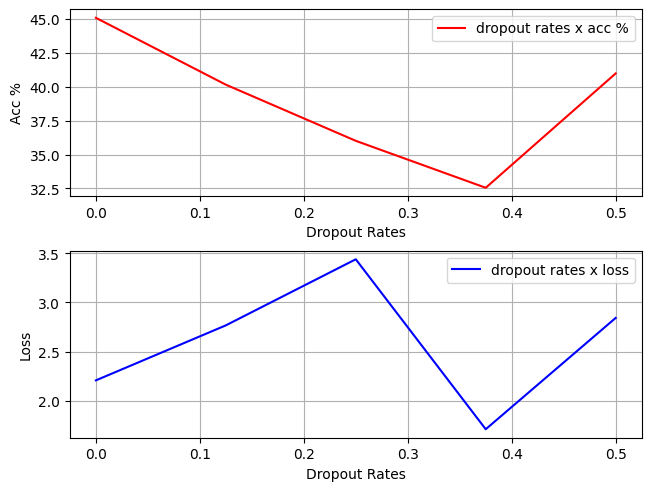

In [ ]:
import pandas as pd
dropout_rates= np.linspace(0,0.5,5) # our list of possible dropout rates
losses_droprate=[]
acc_droprate=[]



for drop_value in dropout_rates:
  net = WideResNet(28, 2, dropout_rate=drop_value, num_classes=num_class)
  net =net.cuda()
  for epoch in range(num_epochs):
    _,_=train(epoch,net,train_loader)
    acc,_ =test(epoch,net,valid_loader)
    # Save checkpoint when best model
    if acc > best_acc:
        print('| Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
        net_save.load_state_dict(net.state_dict(), strict=True)
        best_acc=acc

  _,acc_teste,loss_teste=test_final(net,test_loader)
  losses_droprate.append(loss_teste)
  acc_droprate.append(acc_teste)


fig, axs= plt.subplots(2,1, layout='constrained')

axs[0].plot(dropout_rates,acc_droprate, label='dropout rates x acc %', color='red')
axs[0].set_xlabel('Dropout Rates')
axs[0].set_ylabel('Acc %')
axs[0].grid()
axs[0].legend(loc='upper right')

axs[1].plot(dropout_rates,losses_droprate, label='dropout rates x loss', color='blue')
axs[1].set_xlabel('Dropout Rates')
axs[1].set_ylabel('Loss')
axs[1].grid()
axs[1].legend(loc='upper right')

#predicted_concat = test_final(net,test_loader)


# id_concat =range(len(predicted_concat))
# my_submission = pd.DataFrame({'Id': id_concat,'Expected': predicted_concat})

# # you could use any filename. We choose submission here
# my_submission.to_csv('submission2.csv', index=False)
# print('we have saved the submission !! ')

It seems that ~0.3 is the best value that mixes loss and acc before the overtraining.
Now wew try to test the other factors, like depth and widen factor:



=> Training Epoch #0, LR=0.1000
| Epoch [  0/ 50] Iter[  1/ 32]		Loss: 2.3587 Acc@1: 3.125%
| Epoch [  0/ 50] Iter[ 16/ 32]		Loss: 2.2760 Acc@1: 14.648%
| Epoch [  0/ 50] Iter[ 31/ 32]		Loss: 2.2449 Acc@1: 15.726%

| Validation Epoch #0			Loss: 3.6497 Acc@1: 18.65%

=> Training Epoch #1, LR=0.1000
| Epoch [  1/ 50] Iter[  1/ 32]		Loss: 2.1828 Acc@1: 12.500%
| Epoch [  1/ 50] Iter[ 16/ 32]		Loss: 2.2547 Acc@1: 20.703%
| Epoch [  1/ 50] Iter[ 31/ 32]		Loss: 2.1214 Acc@1: 21.673%

| Validation Epoch #1			Loss: 1.9024 Acc@1: 21.85%

=> Training Epoch #2, LR=0.1000
| Epoch [  2/ 50] Iter[  1/ 32]		Loss: 2.1700 Acc@1: 12.500%
| Epoch [  2/ 50] Iter[ 16/ 32]		Loss: 1.9631 Acc@1: 25.195%
| Epoch [  2/ 50] Iter[ 31/ 32]		Loss: 2.0110 Acc@1: 24.899%

| Validation Epoch #2			Loss: 3.1235 Acc@1: 23.60%

=> Training Epoch #3, LR=0.1000
| Epoch [  3/ 50] Iter[  1/ 32]		Loss: 2.0143 Acc@1: 21.875%
| Epoch [  3/ 50] Iter[ 16/ 32]		Loss: 1.9263 Acc@1: 23.438%
| Epoch [  3/ 50] Iter[ 31/ 32]		Loss: 1.6

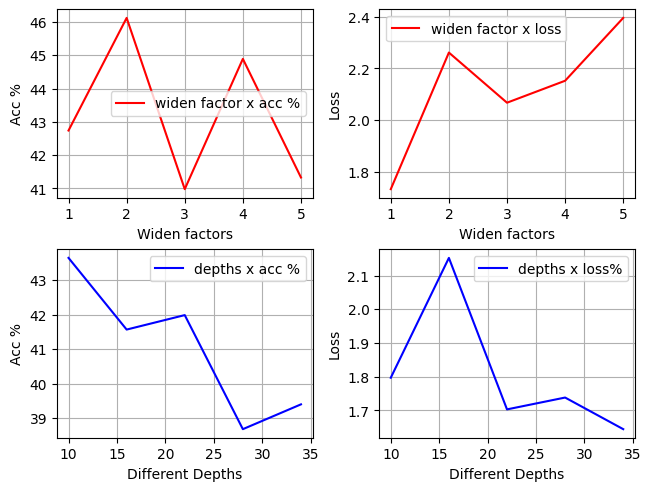

In [ ]:
import pandas as pd
widen_values = [1,2,3,4,5]

depth_values = [6*i + 4 for i in range(1,6)]

acc_widen=[]
acc_depth=[]

losses_widen=[]
losses_depth=[]


for depth_value in depth_values:
  net = WideResNet(depth_value, 2, dropout_rate=0.0, num_classes=num_class)
  net =net.cuda()
  for epoch in range(num_epochs):
    _,_=train(epoch,net,train_loader)
    acc,_ =test(epoch,net,valid_loader)
    # Save checkpoint when best model
    if acc > best_acc:
        print('| Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
        #net_save.load_state_dict(net.state_dict(), strict=True)
        best_acc=acc

  _,acc_teste,loss_teste=test_final(net,test_loader)
  acc_depth.append(acc_teste)
  losses_depth.append(loss_teste)


for widen_value in widen_values:
  net = WideResNet(28, widen_value, dropout_rate=0.0, num_classes=num_class)
  net =net.cuda()
  for epoch in range(num_epochs):
    _,_=train(epoch,net,train_loader)
    acc,_ =test(epoch,net,valid_loader)
    # Save checkpoint when best model
    if acc > best_acc:
        print('| Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
        #net_save.load_state_dict(net.state_dict(), strict=True)
        best_acc=acc

  _,acc_teste,loss_teste=test_final(net,test_loader)
  acc_widen.append(acc_teste)
  losses_widen.append(loss_teste)


fig, axs= plt.subplots(2,2, layout= 'constrained')

axs[0][0].plot(widen_values,acc_widen, label='widen factor x acc %', color='red')
axs[0][0].set_xlabel('Widen factors')
axs[0][0].set_ylabel('Acc %')
axs[0][0].grid()
axs[0][0].legend()

axs[1][0].plot(depth_values,acc_depth, label='depths x acc %', color= 'blue')
axs[1][0].set_xlabel('Different Depths')
axs[1][0].set_ylabel('Acc %')
axs[1][0].legend()
axs[1][0].grid()


axs[0][1].plot(widen_values,losses_widen, label='widen factor x loss', color='red')
axs[0][1].set_xlabel('Widen factors')
axs[0][1].set_ylabel('Loss')
axs[0][1].grid()
axs[0][1].legend()

axs[1][1].plot(depth_values,losses_depth, label='depths x loss%', color= 'blue')
axs[1][1].set_xlabel('Different Depths')
axs[1][1].set_ylabel('Loss')
axs[1][1].legend()
axs[1][1].grid()

Using the loss as the deciding parameter, since it measures how far the distribution given by our net is from the 'truth', we'll choose 22 as the value for depth and 2 for the widen factor.

Now we plot the training loss/acc and the same values for the validation, answering the question made in Q3 about which curve we should also be plotting. Seeing the value of our loss/acc for the validation set is a good way to assess the generalising power of your network and visualize the overfitting in the process.


In [ ]:

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode = 'reflect'),
    #transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
    CutoutDefault(cutout),
])

transform_test = transforms.Compose([
    #transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])

test_loader = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(Original_test_data_x, Original_test_data_y, transform=transform_test),
    batch_size = batch_size,
    shuffle=False, num_workers=2)

train_loader = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(x_train, y_train, transform=transform_train),
    batch_size=batch_size,shuffle=True, num_workers=2) #num_workers = 2 ou 1

valid_loader = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(x_valid, y_valid, transform=transform_test),
    batch_size=batch_size,
    shuffle=False, num_workers=2)

Here we make a small study about the learning rate, that will be reapeated in the latter sections, so we might aswell just explain the reason behing it.

The scheduler function was already in the beggining of the old code, we just tuned it with better epoch thresholds for the models we're using. The main objective is to start with a big enough learning rate to speed the proccess, but decrease its value as we get closer to the loss function's minimum.

We start be finding out that ~70 epochs is where the minimum happens, and from where the model starts to get an overfit. Then we start decreasing the lr's value at 40 epochs, and even more ate 60 and 100. That way, with a decent amount of epochs(like 150, so we won't just waste every free Google Cloud's computing power in a single exercise), the model gets a nice amont of training in that minimum region we want to work with.

In [ ]:
lr=0.1
def learning_rate_scheduler(init, epoch): #correct the learning rate after achieving an error plateau
    optim_factor = 0
    if(epoch > 100):
        optim_factor = 3
    elif(epoch > 60):
        optim_factor = 2
    elif(epoch > 40):
        optim_factor = 1

    return init*math.pow(0.1, optim_factor)



=> Training Epoch #0, LR=0.1000
| Epoch [  0/150] Iter[  1/ 32]		Loss: 2.3293 Acc@1: 18.750%
| Epoch [  0/150] Iter[ 16/ 32]		Loss: 2.0353 Acc@1: 17.383%
| Epoch [  0/150] Iter[ 31/ 32]		Loss: 2.1532 Acc@1: 17.036%

| Validation Epoch #0			Loss: 2.3149 Acc@1: 23.05%

=> Training Epoch #1, LR=0.1000
| Epoch [  1/150] Iter[  1/ 32]		Loss: 2.0457 Acc@1: 12.500%
| Epoch [  1/150] Iter[ 16/ 32]		Loss: 2.2064 Acc@1: 21.680%
| Epoch [  1/150] Iter[ 31/ 32]		Loss: 2.2859 Acc@1: 21.371%

| Validation Epoch #1			Loss: 1.0387 Acc@1: 22.40%

=> Training Epoch #2, LR=0.1000
| Epoch [  2/150] Iter[  1/ 32]		Loss: 1.9100 Acc@1: 34.375%
| Epoch [  2/150] Iter[ 16/ 32]		Loss: 1.8060 Acc@1: 25.391%
| Epoch [  2/150] Iter[ 31/ 32]		Loss: 1.9463 Acc@1: 24.698%

| Validation Epoch #2			Loss: 0.5734 Acc@1: 23.55%

=> Training Epoch #3, LR=0.1000
| Epoch [  3/150] Iter[  1/ 32]		Loss: 1.8560 Acc@1: 21.875%
| Epoch [  3/150] Iter[ 16/ 32]		Loss: 2.0837 Acc@1: 23.438%
| Epoch [  3/150] Iter[ 31/ 32]		Loss: 1.

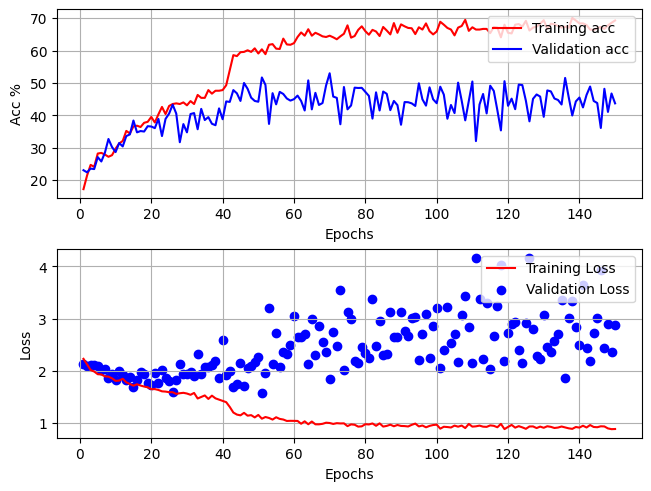

In [ ]:
net = WideResNet(22, 2, dropout_rate=0.25, num_classes=num_class)
net=net.cuda()

loss_training_q0=[]
acc_training_q0=[]

acc_validation_q0=[]
loss_validation_q0=[]
#training the network
for epoch in range(num_epochs):
  loss_training_value,acc_training_value=train(epoch,net,train_loader)
  acc_validation_value,loss_validation_value =test(epoch,net,valid_loader)
  # Save checkpoint when best model
  # if acc_validation_value > best_acc:
  #     print('| Saving Best model...\t\t\tTop1 = %.2f%%' %(acc_validation_value))
  #     net_save.load_state_dict(net.state_dict(), strict=True)
  #     best_acc=acc_validation_value
  acc_validation_q0.append(acc_validation_value)
  loss_validation_q0.append(loss_validation_value)
  acc_training_q0.append(acc_training_value)
  loss_training_q0.append(loss_training_value)
  # _,acc_teste,loss_teste=test_final(net,test_loader)
  # losses_droprate.append(loss_teste)
  # acc_droprate.append(acc_teste)


fig, axs = plt.subplots(2,1,layout='constrained')

axs[0].plot(range(1,num_epochs+1),acc_training_q0, label='Training acc', color='red')
axs[0].plot(range(1,num_epochs+1),acc_validation_q0, label='Validation acc', color='blue')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Acc %')
axs[0].grid()
axs[0].legend(loc='upper right')

axs[1].plot(range(1,num_epochs+1),loss_training_q0, label='Training Loss', color='red')
axs[1].scatter(range(1,num_epochs+1),loss_validation_q0, label='Validation Loss', color='blue')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].grid()
axs[1].legend(loc='upper right')

_,test_ournet_acc,test_ournet_loss=test_final(net,test_loader)

print("Results for our network are: %.2f and %.2f%%" %(test_ournet_loss,test_ournet_acc))




Although we see a big problem with how variable the  accuracy can be, since we're using few labels, our results might be highly dependent if these are good representations of each class. If we get a bad set of labeled training images, than the variance between each run is big.



#Q1 : Changing our DNN with a Resnet 18
PyTorch already has a module for resnet18 that we can call with torchvision.models.resnet18(parameters)

We also create a network without the pre existing weights to train and compare our results.

We also remember to change the size of our pictures, since the article that resnet18 was based from used 224x224x3 examples.

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode = 'reflect'),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
    CutoutDefault(cutout),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])


test_loader = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(Original_test_data_x, Original_test_data_y, transform=transform_test),
    batch_size = batch_size,
    shuffle=False, num_workers=2)

train_loader = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(x_train, y_train, transform=transform_train),
    batch_size=batch_size,shuffle=True, num_workers=2) #num_workers = 2 ou 1

valid_loader = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(x_valid, y_valid, transform=transform_test),
    batch_size=batch_size,
    shuffle=False, num_workers=2)

With the first tests, que can already see that 150 epochs(with the graph we saved from then) was a bit of an overkill, with an LR of 0.1.

![picture](https://drive.google.com/uc?export=view&id=1paAawsH4u5cx7XiLK-MuZ9XIXf4VAyNS)


So we make our LR bigger for the first ~40 epochs and then we start to decrease it even more at ~60 epochs:





In [ ]:
lr=0.1
def learning_rate_scheduler(init, epoch): #correct the learning rate after a certain amount of epochs
    optim_factor = 0
    if(epoch > 80):
        optim_factor = 3
    elif(epoch > 60):
        optim_factor = 2
    elif(epoch > 40):
        optim_factor = 1

    return init*math.pow(0.1, optim_factor)

In [ ]:
num_classes_model=10 #since we're using 10 classes in our program but
#pytorch's pre trained resnet 18 evaluates a 1000 clase problem, we'll change
#the classifier
trained_resnet18=models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
trained_resnet18.fc=nn.Linear(512,num_classes_model)
class TrainedResnet(nn.Module):
  def __init__(self):
    super(TrainedResnet, self).__init__()
    self.bn1 = nn.BatchNorm2d(3,momentum=bn_momentum)
    self.resnet18=trained_resnet18

  def forward(self,x):
    x=F.relu(self.bn1(x))
    x=self.resnet18(x)

    return x

class OurResnet(nn.Module):
  def __init__(self):
    super(OurResnet, self).__init__()
    self.bn1= nn.BatchNorm2d(3,momentum=bn_momentum)
    self.resnet18=models.resnet18()
  def forward(self,x):
    x=F.relu(self.bn1(x))
    x=self.resnet18(x)

    return x

#training

acc_validation_q1=[]
acc_training_q1=[]

loss_validation_q1=[]
loss_training_q1=[]


net=TrainedResnet()
net=net.cuda()

our_net=OurResnet()
our_net=our_net.cuda()

for epoch in range(num_epochs):
  loss_training_value,acc_training_value=train(epoch,our_net,train_loader)
  acc_validation_value,loss_validation_value =test(epoch,our_net,valid_loader)
  # Save checkpoint when best model
  # if acc_training_value > best_acc:
  #     print('| Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
  #     net_save.load_state_dict(net.state_dict(), strict=True)
  #     best_acc=acc_training_value
  acc_validation_q1.append(acc_validation_value)
  loss_validation_q1.append(loss_validation_value)
  acc_training_q1.append(acc_training_value)
  loss_training_q1.append(loss_training_value)


fig, axs = plt.subplots(2,1,layout='constrained')

axs[0].scatter(range(3,num_epochs+1),acc_training_q1[2:], label='Training acc', color='red')
axs[0].scatter(range(3,num_epochs+1),acc_validation_q1[2:], label='Validation acc', color='blue')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Acc %')
axs[0].grid()
axs[0].legend(loc='upper right')

axs[1].scatter(range(3,num_epochs+1),loss_training_q1[2:], label='Training Loss', color='red')
axs[1].scatter(range(3,num_epochs+1),loss_validation_q1[2:], label='Validation Loss', color='blue')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].grid()
axs[1].legend(loc='upper right')

_,test_trainedresnet_acc,test_trainedresnet_loss=test_final(net,test_loader)


_,test_ourresnet_acc,test_ourresnet_loss=test_final(our_net,test_loader)

print("Results for the pre trained network are: %.2f and %.2f%%" %(test_trainedresnet_loss,test_trainedresnet_acc))

print("Results for our network are: %.2f and %.2f%%" %(test_ourresnet_loss,test_ourresnet_acc))

NameError: name 'models' is not defined

Where we see the model we trained ourselves is better.

Using a better server than the one offered freely by Google Cloud, we do a 250 epoch test to our network and find the two following graphs:

![picture](https://drive.google.com/uc?export=view&id=1gaDhfnhFMQb5wNEA30nAUqJ4UrUgnrNo)




If we really push our luck, we can even go to 500 epochs:

![picture](https://drive.google.com/uc?export=view&id=1C_XwdwT4WDwvlCpBkSWyYaigYRBKgIk7)

Where we see the loss seems to have its minimum at around 2 and out accuracy get a little shy out of 50%, with average values at around 45%.

#Q2 : The AlexNet

Now we proceed to the application of the AlexNet.
PyTorch also has a pre-built version of the network, with a natural prediction of 1000 classes. The source code is:

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super(AlexNet,self).__init__()
        #_log_api_usage_once(self)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),

        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Which we leave here just for reference.
But as we can see... we need to change its output's dimension, and maybe add a few batch normalization between each conv layer, as some articles prefer it as a better option to the overfitting problem.

We also begin by changing its inputs dimensions to 227x227x3, the same used in the original paper.


In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode = 'reflect'),
    transforms.Resize((227,227)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
    CutoutDefault(cutout),
])

transform_test = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])


test_loader = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(Original_test_data_x, Original_test_data_y, transform=transform_test),
    batch_size = batch_size,
    shuffle=False, num_workers=2)

train_loader = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(x_train, y_train, transform=transform_train),
    batch_size=batch_size,shuffle=True, num_workers=2) #num_workers = 2 ou 1

valid_loader = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(x_valid, y_valid, transform=transform_test),
    batch_size=batch_size,
    shuffle=False, num_workers=2)

For our study of the learning rate and overfitting of this network, we use the decaying LR.

A first analysis with the original LR decaying rule (the one given by the professor), we have the following loss curve:

![picture](https://drive.google.com/uc?export=view&id=1tZex1kphYZiNJvMTntxCV-njr4NJCldn)

So we start decreasing in the ~40th epoch and then at the 60th. We use the 100th as the last decreasing limit.


In [ ]:

lr=0.1
def learning_rate_scheduler(init, epoch): #correct the learning rate after achieving an error plateau
    optim_factor = 0
    if(epoch > 100):
        optim_factor = 3
    elif(epoch > 60):
        optim_factor = 2
    elif(epoch > 40):
        optim_factor = 1

    return init*math.pow(0.1, optim_factor)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 48.4MB/s]



=> Training Epoch #0, LR=0.1000
| Epoch [  0/150] Iter[  1/ 32]		Loss: 2.3212 Acc@1: 6.250%
| Epoch [  0/150] Iter[ 16/ 32]		Loss: 2.3093 Acc@1: 12.305%
| Epoch [  0/150] Iter[ 31/ 32]		Loss: 2.4173 Acc@1: 12.298%

| Validation Epoch #0			Loss: 2.4337 Acc@1: 14.55%
| Saving Best model...			Top1 = 12.30%

=> Training Epoch #1, LR=0.1000
| Epoch [  1/150] Iter[  1/ 32]		Loss: 2.3614 Acc@1: 21.875%
| Epoch [  1/150] Iter[ 16/ 32]		Loss: 2.6176 Acc@1: 15.234%
| Epoch [  1/150] Iter[ 31/ 32]		Loss: 2.3266 Acc@1: 15.222%

| Validation Epoch #1			Loss: 1.0850 Acc@1: 13.05%
| Saving Best model...			Top1 = 15.30%

=> Training Epoch #2, LR=0.1000
| Epoch [  2/150] Iter[  1/ 32]		Loss: 2.5752 Acc@1: 3.125%
| Epoch [  2/150] Iter[ 16/ 32]		Loss: 2.3432 Acc@1: 10.156%
| Epoch [  2/150] Iter[ 31/ 32]		Loss: 2.3085 Acc@1: 11.996%

| Validation Epoch #2			Loss: 2.1993 Acc@1: 14.45%
| Saving Best model...			Top1 = 12.00%

=> Training Epoch #3, LR=0.1000
| Epoch [  3/150] Iter[  1/ 32]		Loss: 2.2494 Ac

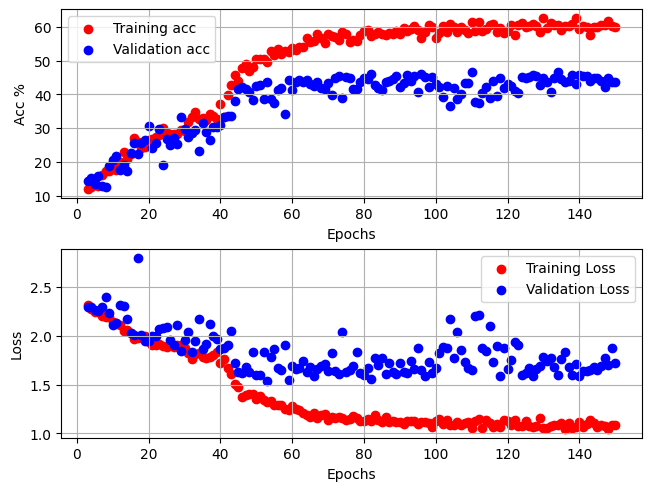

In [ ]:


class TrainedAlexNet(nn.Module):
  def __init__(self):
    super(TrainedAlexNet,self).__init__()
    self.alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
    self.linear1 = nn.Linear(1000,10)
  def forward(self,x):
    x = self.alexnet(x)
    x = self.linear1(x)
    return x

class OurAlexNet(nn.Module):
  def __init__(self):
    super(OurAlexNet,self).__init__()
    self.bn1 = nn.BatchNorm2d(3,momentum=bn_momentum)
    self.features = nn.Sequential(
          nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
          nn.BatchNorm2d(64,momentum=bn_momentum),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=3, stride=2),
          nn.Conv2d(64, 192, kernel_size=5, padding=2),
          nn.BatchNorm2d(192,momentum=bn_momentum),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=3, stride=2),
          nn.Conv2d(192, 384, kernel_size=3, padding=1),
          nn.BatchNorm2d(384,momentum=bn_momentum),
          nn.ReLU(inplace=True),
          nn.Conv2d(384, 256, kernel_size=3, padding=1),
          nn.BatchNorm2d(256,momentum=bn_momentum),
          nn.ReLU(inplace=True),
          nn.Conv2d(256, 256, kernel_size=3, padding=1),
          nn.BatchNorm2d(256,momentum=bn_momentum),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=3, stride=2),
        )
    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
    self.classifier = nn.Sequential(
            nn.Dropout(p=0),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),

        )
  def forward(self,x):
    x= F.relu(self.bn1(x))
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

our_net_save=OurAlexNet()
our_net_save=our_net_save.cuda()

our_net = OurAlexNet()
our_net=our_net.cuda()


trained_net = TrainedAlexNet()
trained_net= trained_net.cuda()

acc_validation_q2=[]
acc_training_q2=[]

loss_validation_q2=[]
loss_training_q2=[]

for epoch in range(num_epochs):
  best_acc=0
  loss_training_value,acc_training_value=train(epoch,our_net,train_loader)
  acc_validation_value,loss_validation_value =test(epoch,our_net,valid_loader)
  # Save checkpoint when best model
  if acc_training_value > best_acc:
       print('| Saving Best model...\t\t\tTop1 = %.2f%%' %(acc_training_value))
       our_net_save.load_state_dict(our_net.state_dict(), strict=True)
       best_acc=acc_training_value
  acc_validation_q2.append(acc_validation_value)
  loss_validation_q2.append(loss_validation_value)
  acc_training_q2.append(acc_training_value)
  loss_training_q2.append(loss_training_value)


fig, axs = plt.subplots(2,1,layout='constrained')

axs[0].scatter(range(3,num_epochs+1),acc_training_q2[2:], label='Training acc', color='red')
axs[0].scatter(range(3,num_epochs+1),acc_validation_q2[2:], label='Validation acc', color='blue')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Acc %')
axs[0].grid()
axs[0].legend(loc='upper left')

axs[1].scatter(range(3,num_epochs+1),loss_training_q2[2:], label='Training Loss', color='red')
axs[1].scatter(range(3,num_epochs+1),loss_validation_q2[2:], label='Validation Loss', color='blue')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].grid()
axs[1].legend(loc='upper right')

_,test_trainedresnet_acc,test_trainedresnet_loss=test_final(trained_net,test_loader)


_,test_ourresnet_acc,test_ourresnet_loss=test_final(our_net,test_loader)

print("Results for the pre trained network are: %.2f and %.2f%%" %(test_trainedresnet_loss,test_trainedresnet_acc))

print("Results for our network are: %.2f and %.2f%%" %(test_ourresnet_loss,test_ourresnet_acc))

Here the accuracy plays around de 35% and 40% interval.

# Q3 - SVM and Random Forest

We now move to the 3rd question, where we need to make some modifications to use the scikit tools, like going back to the 32x32x3 format.

We begin by extracting the data so we can use it in the new models:

In [ ]:

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode = 'reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
    CutoutDefault(cutout),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])


In [ ]:
# Extract data for random forest

extracted_test_loader = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(Original_test_data_x, Original_test_data_y, transform=transform_test),
    batch_size = 1, shuffle=False, num_workers=2)

extracted_train_loader = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(x_train, y_train, transform=transform_train),
    batch_size=1,shuffle=True, num_workers=2)

In [ ]:
# conversion of interpretability

extracted_x_test = []
extracted_y_test = []

for (image, targets) in extracted_test_loader:
    extracted_x_test.append(np.asarray(((image[0]).squeeze()).permute(1, 2, 0)))
    extracted_y_test.append((targets[0]).item())

extracted_x_train = []
extracted_y_train = []

for (image, targets) in extracted_train_loader:
    extracted_x_train.append(np.asarray(((image[0]).squeeze()).permute(1, 2, 0)))
    extracted_y_train.append((targets[0]).item())

In [ ]:
print("Size of:")
print("Training-set:\t\t{}".format(len(extracted_x_train)))
print("Test-set:\t\t{}".format(len(extracted_x_test)))

Size of:
Training-set:		1000
Test-set:		10000


We now reshape it to feed it to both models:

In [ ]:
# reshape for training

(x_test_a, x_test_b, x_test_c, x_test_d) = np.shape(extracted_x_test)
extracted_x_test = np.asarray(extracted_x_test).reshape(x_test_a, x_test_b * x_test_c * x_test_d)

(x_train_a, x_train_b, x_train_c, x_train_d) = np.shape(extracted_x_train)
extracted_x_train = np.asarray(extracted_x_train).reshape(x_train_a, x_train_b * x_train_c * x_train_d)

For Random Trees, we have:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as perf

clf = RandomForestClassifier(n_jobs=5,n_estimators=100)
clf.fit(extracted_x_train, extracted_y_train)

extracted_y_pred = clf.predict(extracted_x_test)
correct_tree = perf.accuracy_score(extracted_y_test, extracted_y_pred)

print('Prediction Error: {:.1f}%'.format(100*(1 - correct_tree)) + ' Number of classes: '+ str(clf.n_classes_) )

cm = perf.confusion_matrix(extracted_y_test, extracted_y_pred)
print(cm)

Prediction Error: 70.1% Number of classes: 10
[[482  28  47  29  34  31  28  13 251  57]
 [116 236  21  74  36  76  84  34 111 212]
 [190  36 158  96 191  58 134  40  55  42]
 [123  50  81 205  84 150 113  51  42 101]
 [ 79  24 129  79 318  83 147  55  51  35]
 [108  31  76 196  93 246  93  64  45  48]
 [101  29 101 150 176  78 283  32  18  32]
 [147  26  49  77 128 120  63 176  59 155]
 [162  63  15  38  26  62  17  10 499 108]
 [172 112   8  39  19  31  40  44 146 389]]


We can also use bagging:

In [ ]:
# Bagging
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(clf, n_estimators=50, max_samples=0.8, bootstrap_features=False, max_features=0.5)
bagging.fit(extracted_x_train, extracted_y_train)

extracted_y_pred = bagging.predict(extracted_x_test)
correct_bagging = perf.accuracy_score(extracted_y_test, extracted_y_pred)

print('Prediction Error: {:.1f}%'.format(100*(1 - correct_bagging)) + ' Number of classes: '+ str(bagging.n_classes_) )

cm = perf.confusion_matrix(extracted_y_test, extracted_y_pred)
print(cm)

Prediction Error: 68.1% Number of classes: 10
[[488  13  39  17  39  30  40   7 273  54]
 [105 161  17  79  33  76 111  27 144 247]
 [198  25 168  73 208  44 160  25  63  36]
 [144  29  67 198  80 159 136  41  38 108]
 [ 82  10 125  61 369  64 159  33  55  42]
 [118  14  75 172  96 264 122  40  46  53]
 [105   9  94 110 167  60 376  21  21  37]
 [132  11  34  65 150 116  92 164  62 174]
 [125  50  13  31  25  64  19   9 538 126]
 [151  70   5  26  25  33  53  24 149 464]]


For the SVMs :

In [ ]:
from sklearn.linear_model import SGDClassifier

clf_svm = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
clf_svm.fit(extracted_x_train, extracted_y_train)

extracted_y_pred = clf_svm.predict(extracted_x_test)
correct_svm = perf.accuracy_score(extracted_y_test, extracted_y_pred)

print('Prediction Error: {:.1f}%'.format(100*(1 - correct_svm))+' Number of classes: ' + str(len(clf_svm.classes_)))

cm = perf.confusion_matrix(extracted_y_test, extracted_y_pred)
print(cm)

Prediction Error: 76.0% Number of classes: 10
[[328  89 107  22  57  17  33  41 234  72]
 [ 96 176  69  67  53  84  67  47 116 225]
 [ 85  53 175  69 141  68 175  69 108  57]
 [ 71  82 103 123  97 176 146  70  63  69]
 [ 58  32 126  65 244  99 205  82  44  45]
 [ 63  61 116 153 123 201 116  60  60  47]
 [ 39  38  92  85 128 110 321  69  38  80]
 [ 98  60 103  68 162  75  90 199  60  85]
 [194 129  58  23  38  44  15  18 367 114]
 [127 187  67  43  55  46  54  39 117 265]]


#Q4 - Model Comparation

To compare all the models in Questions 0 - 2, we plot their loss and accuracy per epoch curves :
(nice to mention the same isn't really possible for the SVM and trees, since the training doesn't involve epochs, but we'll make a table afterwards)

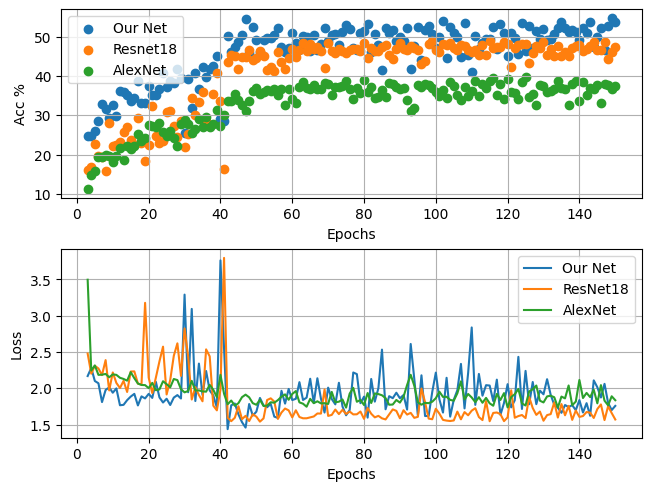

In [ ]:
fig , axs = plt.subplots(2,1,layout='constrained')

#axs[0].scatter(range(3,num_epochs+1),acc_training_q0[2:], label='Our Net')
axs[0].scatter(range(3,num_epochs+1),acc_validation_q0[2:], label='Our Net')
#axs[0].scatter(range(3,num_epochs+1),acc_training_q1[2:], label='Resnet18')
axs[0].scatter(range(3,num_epochs+1),acc_validation_q1[2:], label='Resnet18')
#axs[0].scatter(range(3,num_epochs+1),acc_training_q2[2:], label='AlexNet')
axs[0].scatter(range(3,num_epochs+1),acc_validation_q2[2:], label='AlexNet')

axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Acc %')
axs[0].grid()
axs[0].legend(loc='upper left')

#axs[1].scatter(range(3,num_epochs+1),loss_training_q0[2:], label='Our Net')
axs[1].plot(range(3,num_epochs+1),loss_validation_q0[2:], label='Our Net')
#axs[1].scatter(range(3,num_epochs+1),loss_training_q1[2:], label='ResNet18')
axs[1].plot(range(3,num_epochs+1),loss_validation_q1[2:], label='ResNet18')
#axs[1].scatter(range(3,num_epochs+1),loss_training_q2[2:], label='AlexNet')
axs[1].plot(range(3,num_epochs+1),loss_validation_q2[2:], label='AlexNet')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].grid()
axs[1].legend(loc='upper right')

Where ResNet18, even if it doesn't own the best accuracy curve, still has the smaller loss between the three models.


Making a table to gather the differente accuracies and losses:

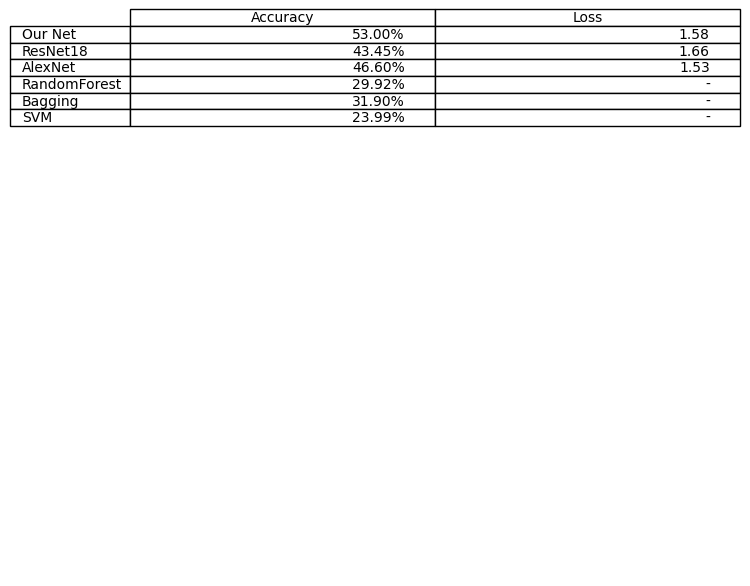

In [ ]:
rows= ['Our Net', 'ResNet18' , 'AlexNet' , 'RandomForest', 'Bagging', 'SVM']

columns = ['Accuracy', 'Loss']

cell_text=[[f'{max(acc_validation_q0):.2f}%',f'{min(loss_validation_q0):.2f}'],
 [f'{max(acc_validation_q1):.2f}%',f'{min(loss_validation_q1):.2f}'],
 [f'{max(acc_validation_q2):.2f}%',f'{min(loss_validation_q2):.2f}'],
  [f'{100*correct_tree:.2f}%','-'],
   [f'{100*correct_bagging:.2f}%','-'],
    [f'{100*correct_svm:.2f}%','-']]

# cell_text=[[str(max(range(5))) + "%",str(min(range(5)))],
#  [str(max(range(5)))+ "%",str(min(range(5)))],
#  [str(max(range(50))) + "%",str(min(range(5)))],
#   [str(100*0.5) + "%",'-'],
#    [str(100*0.4)+ "%",'-'],
#     [str(100*0.3)+ "%",'-']]

fig,axs=plt.subplots()
fig.patch.set_visible(False)
axs.axis('off')
axs.axis('tight')
fig.tight_layout()
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      #rowColours=colors,
                      colLabels=columns,loc= 'top')

In case the colab won't ship with our graphs, here's how the tables ended up looking like:

![picture](https://drive.google.com/uc?export=view&id=1SMp5aW-AOTgcj-iDNl07f-u740YhEIvO)

![picture](https://drive.google.com/uc?export=view&id=1pMiBX16TeOFLQyaOhDBxfvCOOxZVhwev)

#Q5 - Our explanation of the FixMatch

The FixMatch algorithm can be decomposed into 6 smaller steps.

1. The batch of labeled images has a size of $B$, while the batch of unlabeled images will have a size of $\mu B$, where $\mu$ is a hyperparameter that describes the proportion of unlabeled images in the dataset.
2. Starting only from the labeled images of the dataset, we train the network in a supervised manner. The loss of the supervised training is then calculated and denoted by $l_s$.
$$l_s = \dfrac{1}{B} \sum_{b=1}^B H\left(p_b, p_m\left((y \,|\, \alpha(x_b)\right)\right)$$
3. Each unlabeled image will undergo two distinct transformations: a weak one ($\alpha$) and a strong one ($A$). The weak transformation typically involves flipping the image and translating it, while the strong transformation involves rotations, cropping, color alterations, etc.
4. Each weak transformation will be predicted by the supervised training, generating a probability distribution for the respective classes. If the maximum value of this distribution is higher than a certain threshold $\tau$, then the class associated with this value will be labeled as a pseudo-label $\hat{q}_b$. Otherwise, the image will not be used in the new training.
$$q_b = p_m\left(y \,|\, \alpha(u_b)\right)$$
$$\hat{q}_b = \arg\max(q_b)$$
5. The strong transformation will then be predicted by the supervised training, generating a new probability distribution that combines with the respective pseudo-label through Cross Entropy Loss. The union $l_u$ of all these losses is given as the average of the cross-entropy losses of each batch.
$$l_u = \dfrac{1}{\mu B} \sum_{b=1}^{\mu B} 1(\max(q_b) \geq \tau) \, H\left(\hat{q}_b, p_m\left((y \,|\, A(u_b)\right)\right)$$
6. The total loss is given by:
$$\text{loss} = l_s + \lambda_u \, l_u$$
where $\lambda_u$ is a hyperparameter that determines the importance of the unlabeled images in this new training. From this new loss, the model is then optimized.

# Q6 - FixMatch implementation

The [unofficial implementation](https://github.com/kekmodel/FixMatch-pytorch) was used as a basis, which has an MIT license for use. Furthermore, the [original implementation](https://github.com/google-research/fixmatch) was also used as support.

## 0. Parameters

In [ ]:
NUM_LABELED = 100
EPOCHS = 50
BATCH_SIZE = 16
LR = 0.03
W_DECAY = 0.001
EMA_DECAY = 0.999
EVAL_STEP = 1024
LAMBDA_U = 1.0
MU_FACTOR = 7
THRESHOLD = 0.95
SEED = 5
NUM_WORKERS = 2
NESTEROV = True
WARMUP = 0
TOTAL_STEPS = 2**20

## 1. Import modules

In [ ]:
import os
import time
import shutil
import argparse

from copy import deepcopy

import math
import random

import logging
import numpy as np

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import LambdaLR

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

import PIL
from PIL import Image

from torchvision import datasets
from torchvision import transforms


logger = logging.getLogger(__name__)

## 2. Augmentation functions

In [ ]:
PARAMETER_MAX = 10

CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2471, 0.2435, 0.2616)


def AutoContrast(img, **kwarg):
    return PIL.ImageOps.autocontrast(img)


def Brightness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Color(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Color(img).enhance(v)


def Contrast(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Cutout(img, v, max_v, bias=0):
    if v == 0:
        return img

    v = _float_parameter(v, max_v) + bias
    v = int(v * min(img.size))
    return CutoutAbs(img, v)


def CutoutAbs(img, v, **kwarg):
    w, h = img.size
    x0 = np.random.uniform(0, w)
    y0 = np.random.uniform(0, h)
    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = int(min(w, x0 + v))
    y1 = int(min(h, y0 + v))
    xy = (x0, y0, x1, y1)
    color = (127, 127, 127)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def Equalize(img, **kwarg):
    return PIL.ImageOps.equalize(img)


def Identity(img, **kwarg):
    return img


def Invert(img, **kwarg):
    return PIL.ImageOps.invert(img)


def Posterize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.posterize(img, v)


def Rotate(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    if np.random.uniform() < 0.5:
        v = -v

    return img.rotate(v)


def Sharpness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Sharpness(img).enhance(v)


def ShearX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if np.random.uniform() < 0.5:
        v = -v

    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if np.random.uniform() < 0.5:
        v = -v

    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def Solarize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.solarize(img, 256 - v)


def SolarizeAdd(img, v, max_v, bias=0, threshold=128):
    v = _int_parameter(v, max_v) + bias
    if np.random.uniform() < 0.5:
        v = -v

    img_np = np.array(img).astype(np.int)
    img_np = img_np + v
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def TranslateX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if np.random.uniform() < 0.5:
        v = -v

    v = int(v * img.size[0])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if np.random.uniform() < 0.5:
        v = -v

    v = int(v * img.size[1])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def _float_parameter(v, max_v):
    return float(v) * max_v / PARAMETER_MAX


def _int_parameter(v, max_v):
    return int(v * max_v / PARAMETER_MAX)


def fixmatch_augment_pool():
    augs = [
        (AutoContrast, None, None),
        (Brightness, 0.9, 0.05),
        (Color, 0.9, 0.05),
        (Contrast, 0.9, 0.05),
        (Equalize, None, None),
        (Identity, None, None),
        (Posterize, 4, 4),
        (Rotate, 30, 0),
        (Sharpness, 0.9, 0.05),
        (ShearX, 0.3, 0),
        (ShearY, 0.3, 0),
        (Solarize, 256, 0),
        (TranslateX, 0.3, 0),
        (TranslateY, 0.3, 0)
    ]

    return augs


class RandAugmentMC(object):
    def __init__(self, n, m):
        assert n >= 1
        assert 1 <= m <= 10
        self.n = n
        self.m = m
        self.augment_pool = fixmatch_augment_pool()

    def __call__(self, img):
        ops = random.choices(self.augment_pool, k=self.n)
        for op, max_v, bias in ops:
            v = np.random.randint(1, self.m)
            if np.random.uniform() < 0.5:
                img = op(img, v=v, max_v=max_v, bias=bias)

        img = CutoutAbs(img, int(32*0.5))
        return img

## 3. Prepares CIFAR10 dataset

In [ ]:
# Parameters of WideResNet
num_classes = 10
model_depth = 28
model_width = 2


def x_u_split(labels):
    label_per_class = NUM_LABELED // num_classes
    labels = np.array(labels)

    labeled_idx = []
    unlabeled_idx = np.array(range(len(labels)))

    for i in range(num_classes):
        idx = np.where(labels == i)[0]
        idx = np.random.choice(idx, label_per_class, False)
        labeled_idx.extend(idx)

    labeled_idx = np.array(labeled_idx)
    assert len(labeled_idx) == NUM_LABELED

    num_expand_x = np.ceil(
        BATCH_SIZE * EVAL_STEP / NUM_LABELED).astype(int)

    labeled_idx = np.hstack([labeled_idx for _ in range(num_expand_x)])

    np.random.shuffle(labeled_idx)
    return labeled_idx, unlabeled_idx


class TransformFixMatch(object):
    def __init__(self, mean, std):
        self.weak = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(
                size=32, padding=4, padding_mode='reflect')
        ])

        self.strong = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(
                size=32, padding=4, padding_mode='reflect'),
            RandAugmentMC(n=2, m=10)
        ])

        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=mean, std=std)
        ])

    def __call__(self, x):
        weak = self.weak(x)
        strong = self.strong(x)
        return self.normalize(weak), self.normalize(strong)


class CIFAR10SSL(datasets.CIFAR10):
    def __init__(self, root, indices, train=True,
                 transform=None, target_transform=None,
                 download=False):
        super().__init__(root, train=train,
                         transform=transform,
                         target_transform=target_transform,
                         download=download)

        if indices is not None:
            self.data = self.data[indices]
            self.targets = np.array(self.targets)[indices]

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


def get_cifar10(root):
    transform_labeled = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(
            size=32, padding=4, padding_mode='reflect'),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=CIFAR10_MEAN, std=CIFAR10_STD)
    ])

    transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=CIFAR10_MEAN, std=CIFAR10_STD)
    ])

    base_dataset = datasets.CIFAR10(root, train=True, download=True)

    train_labeled_idxs, train_unlabeled_idxs = x_u_split(
        base_dataset.targets)

    train_labeled_dataset = CIFAR10SSL(
        root, train_labeled_idxs, train=True, transform=transform_labeled)

    train_unlabeled_dataset = CIFAR10SSL(
        root, train_unlabeled_idxs, train=True,
        transform=TransformFixMatch(
            mean=CIFAR10_MEAN, std=CIFAR10_STD)
    )

    test_dataset = datasets.CIFAR10(
        root, train=False, transform=transform_val, download=False)

    return train_labeled_dataset, train_unlabeled_dataset, test_dataset

## 4. Defines network architecture (WideResNet)

In [ ]:
class ModelEMA(object):
    def __init__(self, device, model, decay):
        self.ema = deepcopy(model)
        self.ema.to(device)
        self.ema.eval()
        self.decay = decay
        self.ema_has_module = hasattr(self.ema, 'module')
        self.param_keys = [k for k, _ in self.ema.named_parameters()]
        self.buffer_keys = [k for k, _ in self.ema.named_buffers()]

        for p in self.ema.parameters():
            p.requires_grad_(False)

    def update(self, model):
        needs_module = hasattr(model, 'module') and not self.ema_has_module

        with torch.no_grad():
            msd = model.state_dict()
            esd = self.ema.state_dict()

            for k in self.param_keys:
                j = 'module.' + k if needs_module else k
                model_v = msd[j].detach()
                ema_v = esd[k]
                esd[k].copy_(ema_v * self.decay + (1. - self.decay) * model_v)

            for k in self.buffer_keys:
                j = 'module.' + k if needs_module else k
                esd[k].copy_(msd[j])


def mish(x):
    """
    Mish: A Self Regularized Non-Monotonic Neural
    Activation Function (https://arxiv.org/abs/1908.08681)
    """

    return x * torch.tanh(F.softplus(x))


class PSBatchNorm2d(nn.BatchNorm2d):
    """
    How Does BN Increase Collapsed Neural Network
    Filters? (https://arxiv.org/abs/2001.11216)
    """

    def __init__(self, num_features, alpha=0.1, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True):
        super().__init__(num_features, eps, momentum, affine, track_running_stats)
        self.alpha = alpha

    def forward(self, x):
        return super().forward(x) + self.alpha


class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, drop_rate=0.0, activate_before_residual=False):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes, momentum=0.001)
        self.relu1 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes, momentum=0.001)
        self.relu2 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.drop_rate = drop_rate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                                                                padding=0, bias=False) or None
        self.activate_before_residual = activate_before_residual

    def forward(self, x):
        if not self.equalInOut and self.activate_before_residual == True:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.drop_rate > 0:
            out = F.dropout(out, p=self.drop_rate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)


class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, drop_rate=0.0, activate_before_residual=False):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(
            block, in_planes, out_planes, nb_layers, stride, drop_rate, activate_before_residual)

    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, drop_rate, activate_before_residual):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes,
                                i == 0 and stride or 1, drop_rate, activate_before_residual))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, num_classes, depth=28, widen_factor=2, drop_rate=0.0):
        super(WideResNet, self).__init__()
        channels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(
            n, channels[0], channels[1], block, 1, drop_rate, activate_before_residual=True)
        # 2nd block
        self.block2 = NetworkBlock(
            n, channels[1], channels[2], block, 2, drop_rate)
        # 3rd block
        self.block3 = NetworkBlock(
            n, channels[2], channels[3], block, 2, drop_rate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(channels[3], momentum=0.001)
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.fc = nn.Linear(channels[3], num_classes)
        self.channels = channels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(-1, self.channels)
        return self.fc(out)


def build_wideresnet(depth, widen_factor, dropout, num_classes):
    logger.info(f"Model: WideResNet {depth}x{widen_factor}")
    return WideResNet(depth=depth,
                      widen_factor=widen_factor,
                      drop_rate=dropout,
                      num_classes=num_classes)

## 5. Utility functions

In [ ]:
def accuracy(output, target, topk=(1,)):
    """
    Computes the precision@k for the specified values of k
    """

    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


class AverageMeter(object):
    """
    Computes and stores the average and current value
    Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def save_checkpoint(state, is_best, checkpoint, filename='checkpoint.pth.tar'):
    filepath = os.path.join(checkpoint, filename)
    torch.save(state, filepath)

    if is_best:
        shutil.copyfile(
            filepath, os.path.join(checkpoint, 'model_best.pth.tar'))


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    try:
        torch.cuda.manual_seed_all(seed)
    except:
      pass


def get_cosine_schedule_with_warmup(optimizer,
                                    num_warmup_steps,
                                    num_training_steps,
                                    num_cycles=7./16.,
                                    last_epoch=-1):
    def _lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))

        no_progress = float(current_step - num_warmup_steps) / \
            float(max(1, num_training_steps - num_warmup_steps))

        return max(0., math.cos(math.pi * num_cycles * no_progress))

    return LambdaLR(optimizer, _lr_lambda, last_epoch)


def interleave(x, size):
    s = list(x.shape)
    return x.reshape([-1, size] + s[1:]).transpose(0, 1).reshape([-1] + s[1:])


def de_interleave(x, size):
    s = list(x.shape)
    return x.reshape([size, -1] + s[1:]).transpose(0, 1).reshape([-1] + s[1:])

## 6. Network trainning

In [ ]:
best_acc = 0.0

def train(device, writer, labeled_trainloader, unlabeled_trainloader, test_loader,
          model, optimizer, ema_model, scheduler, out):
    global best_acc

    test_accs = []
    end = time.time()

    labeled_iter = iter(labeled_trainloader)
    unlabeled_iter = iter(unlabeled_trainloader)

    model.train()
    for epoch in range(EPOCHS):
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        losses_x = AverageMeter()
        losses_u = AverageMeter()
        mask_probs = AverageMeter()
        p_bar = tqdm(
            range(EVAL_STEP), disable=False)

        for batch_idx in range(EVAL_STEP):
            try:
                inputs_x, targets_x = next(labeled_iter)
            except:
                labeled_iter = iter(labeled_trainloader)
                inputs_x, targets_x = next(labeled_iter)

            try:
                (inputs_u_w, inputs_u_s), _ = next(unlabeled_iter)
            except:
                unlabeled_iter = iter(unlabeled_trainloader)
                (inputs_u_w, inputs_u_s), _ = next(unlabeled_iter)

            data_time.update(time.time() - end)
            batch_size = inputs_x.shape[0]
            inputs = interleave(
                torch.cat((inputs_x, inputs_u_w, inputs_u_s)), 2*MU_FACTOR+1).to(device)
            targets_x = targets_x.type(torch.LongTensor)
            targets_x = targets_x.to(device)
            logits = model(inputs)
            logits = de_interleave(logits, 2*MU_FACTOR+1)
            logits_x = logits[:batch_size]
            logits_u_w, logits_u_s = logits[batch_size:].chunk(2)
            del logits

            Lx = F.cross_entropy(logits_x, targets_x, reduction='mean')

            pseudo_label = torch.softmax(logits_u_w.detach(), dim=-1)
            max_probs, targets_u = torch.max(pseudo_label, dim=-1)
            mask = max_probs.ge(THRESHOLD).float()

            Lu = (F.cross_entropy(logits_u_s, targets_u,
                                  reduction='none') * mask).mean()

            loss = Lx + LAMBDA_U * Lu
            loss.backward()

            losses.update(loss.item())
            losses_x.update(Lx.item())
            losses_u.update(Lu.item())
            optimizer.step()
            scheduler.step()
            ema_model.update(model)
            model.zero_grad()

            batch_time.update(time.time() - end)
            end = time.time()
            mask_probs.update(mask.mean().item())
            p_bar.set_description("Train Epoch: {epoch}/{epochs:4}. Iter: {batch:4}/{iter:4}. LR: {lr:.4f}. Data: {data:.3f}s. Batch: {bt:.3f}s. Loss: {loss:.4f}. Loss_x: {loss_x:.4f}. Loss_u: {loss_u:.4f}. Mask: {mask:.2f}. ".format(
                epoch=epoch + 1,
                epochs=EPOCHS,
                batch=batch_idx + 1,
                iter=EVAL_STEP,
                lr=scheduler.get_last_lr()[0],
                data=data_time.avg,
                bt=batch_time.avg,
                loss=losses.avg,
                loss_x=losses_x.avg,
                loss_u=losses_u.avg,
                mask=mask_probs.avg))
            p_bar.update()

        p_bar.close()

        test_model = ema_model.ema

        test_loss, test_acc = test(device, test_loader, test_model, epoch)

        writer.add_scalar('train/1.train_loss', losses.avg, epoch)
        writer.add_scalar('train/2.train_loss_x', losses_x.avg, epoch)
        writer.add_scalar('train/3.train_loss_u', losses_u.avg, epoch)
        writer.add_scalar('train/4.mask', mask_probs.avg, epoch)
        writer.add_scalar('test/1.test_acc', test_acc, epoch)
        writer.add_scalar('test/2.test_loss', test_loss, epoch)

        is_best = test_acc > best_acc
        best_acc = max(test_acc, best_acc)

        model_to_save = model.module if hasattr(model, "module") else model
        ema_to_save = ema_model.ema.module if hasattr(
            ema_model.ema, "module") else ema_model.ema

        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model_to_save.state_dict(),
            'ema_state_dict': ema_to_save.state_dict(),
            'acc': test_acc,
            'best_acc': best_acc,
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
        }, is_best, out)

        test_accs.append(test_acc)
        logger.info('Best top-1 acc: {:.2f}'.format(best_acc))
        logger.info('Mean top-1 acc: {:.2f}\n'.format(
            np.mean(test_accs[-20:])))

    writer.close()

## 7. Tests and accuracy computation

In [ ]:
def test(device, test_loader, model, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    end = time.time()

    test_loader = tqdm(
        test_loader, disable=False)

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            data_time.update(time.time() - end)
            model.eval()

            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, targets)

            prec1, prec5 = accuracy(outputs, targets, topk=(1, 5))
            losses.update(loss.item(), inputs.shape[0])
            top1.update(prec1.item(), inputs.shape[0])
            top5.update(prec5.item(), inputs.shape[0])
            batch_time.update(time.time() - end)
            end = time.time()

            test_loader.set_description("Test Iter: {batch:4}/{iter:4}. Data: {data:.3f}s. Batch: {bt:.3f}s. Loss: {loss:.4f}. top1: {top1:.2f}. top5: {top5:.2f}. ".format(
                batch=batch_idx + 1,
                iter=len(test_loader),
                data=data_time.avg,
                bt=batch_time.avg,
                loss=losses.avg,
                top1=top1.avg,
                top5=top5.avg,
            ))

        test_loader.close()

    logger.info("top-1 acc: {:.2f}".format(top1.avg))
    logger.info("top-5 acc: {:.2f}".format(top5.avg))
    return losses.avg, top1.avg

## 8. Main function

In [ ]:
def main(out):
    global best_acc, num_classes, model_depth, model_width

    device = torch.device('cuda', 0)
    world_size = 1
    n_gpu = torch.cuda.device_count()

    set_seed(SEED)

    os.makedirs(out, exist_ok=True)
    writer = SummaryWriter(out)

    labeled_dataset, unlabeled_dataset, test_dataset = get_cifar10('./data')
    train_sampler = RandomSampler

    labeled_trainloader = DataLoader(
        labeled_dataset,
        sampler=train_sampler(labeled_dataset),
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        drop_last=True)

    unlabeled_trainloader = DataLoader(
        unlabeled_dataset,
        sampler=train_sampler(unlabeled_dataset),
        batch_size=BATCH_SIZE*MU_FACTOR,
        num_workers=NUM_WORKERS,
        drop_last=True)

    test_loader = DataLoader(
        test_dataset,
        sampler=SequentialSampler(test_dataset),
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS)

    model = build_wideresnet(
        depth=model_depth,
        widen_factor=model_width,
        dropout=0,
        num_classes=num_classes
    )

    logger.info("Total params: {:.2f}M".format(
        sum(p.numel() for p in model.parameters())/1e6))

    model.to(device)

    no_decay = ['bias', 'bn']
    grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(
            nd in n for nd in no_decay)], 'weight_decay': W_DECAY},
        {'params': [p for n, p in model.named_parameters() if any(
            nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

    optimizer = optim.SGD(
        grouped_parameters, lr=LR,
        momentum=0.9, nesterov=NESTEROV
    )

    scheduler = get_cosine_schedule_with_warmup(
        optimizer, WARMUP, TOTAL_STEPS)

    ema_model = ModelEMA(device, model, EMA_DECAY)

    logger.info("***** Running training *****")
    logger.info(f"  Task = cifar10@{NUM_LABELED}")
    logger.info(f"  Num Epochs = {EPOCHS}")
    logger.info(f"  Batch size per GPU = {BATCH_SIZE}")
    logger.info(
        f"  Total train batch size = {BATCH_SIZE}")
    logger.info(f"  Total optimization steps = {TOTAL_STEPS}")

    model.zero_grad()
    train(device, writer, labeled_trainloader, unlabeled_trainloader, test_loader,
          model, optimizer, ema_model, scheduler, out)

if __name__ == '__main__':
    main("results/cifar10@100")

100%|██████████| 170498071/170498071 [00:10<00:00, 15901322.36it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


Train Epoch: 1/  50. Iter: 1024/1024. LR: 0.0300. Data: 0.044s. Batch: 0.181s. Loss: 0.6280. Loss_x: 0.4440. Loss_u: 0.1840. Mask: 0.19. : 100%|██████████| 1024/1024 [03:04<00:00,  5.55it/s]
Test Iter:  625/ 625. Data: 0.005s. Batch: 0.014s. Loss: 2.4028. top1: 26.39. top5: 77.37. : 100%|██████████| 625/625 [00:08<00:00, 69.90it/s]
Train Epoch: 2/  50. Iter: 1024/1024. LR: 0.0300. Data: 0.056s. Batch: 0.192s. Loss: 0.3479. Loss_x: 0.0792. Loss_u: 0.2686. Mask: 0.31. : 100%|██████████| 1024/1024 [03:07<00:00,  5.47it/s]
Test Iter:  625/ 625. Data: 0.004s. Batch: 0.013s. Loss: 2.9657. top1: 30.77. top5: 82.15. : 100%|██████████| 625/625 [00:08<00:00, 76.94it/s]
Train Epoch: 3/  50. Iter: 1024/1024. LR: 0.0300. Data: 0.053s. Batch: 0.190s. Loss: 0.3313. Loss_x: 0.0674. Loss_u: 0.2639. Mask: 0.33. : 100%|██████████| 1024/1024 [03:06<00:00,  5.50it/s]
Test Iter:  625/ 625. Data: 0.006s. Batch: 0.014s. Loss: 3.2664. top1: 32.34. top5: 83.14. : 100%|██████████| 625/625 [00:08<00:00, 69.58it/s

## 9. Results

Using 50 epochs, it is estimated that the training with only 100 labeled images lasted less than 3 hours, going from an accuracy of 26.39% to 62.25%, very close to the result of the reference paper.

On a dedicated server, we conducted two larger tests of 150 epochs, one starting with 100 labeled images (blue line) and the other with 1000 labeled images (red line). The graphs comparing the accuracy and loss are provided below.

**Observation:** the code output consists of a set of files saved with the training checkpoints and the best model. These files have direct integration with Tensorboard for generating graphs and data analysis, so we will add the plots extracted from there.

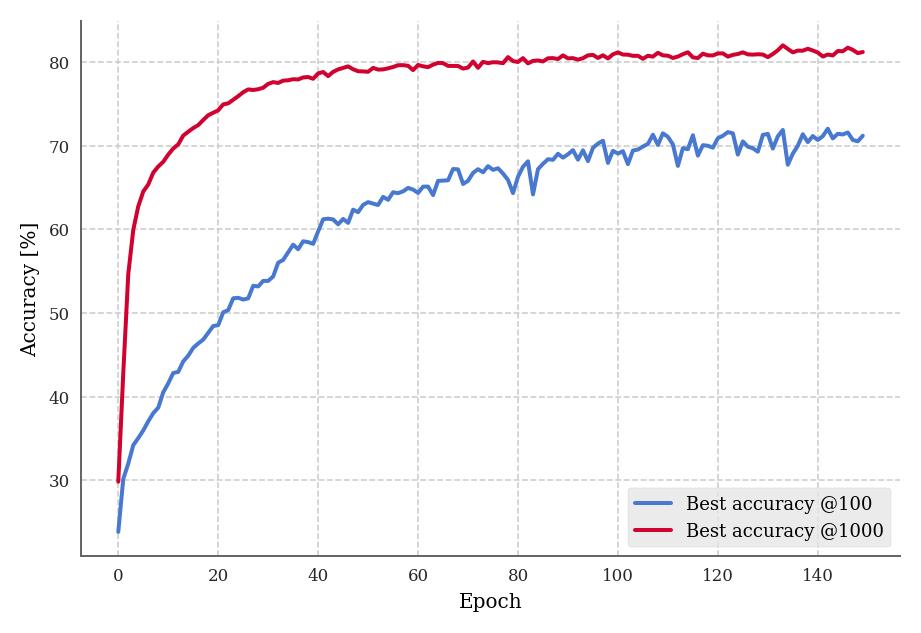

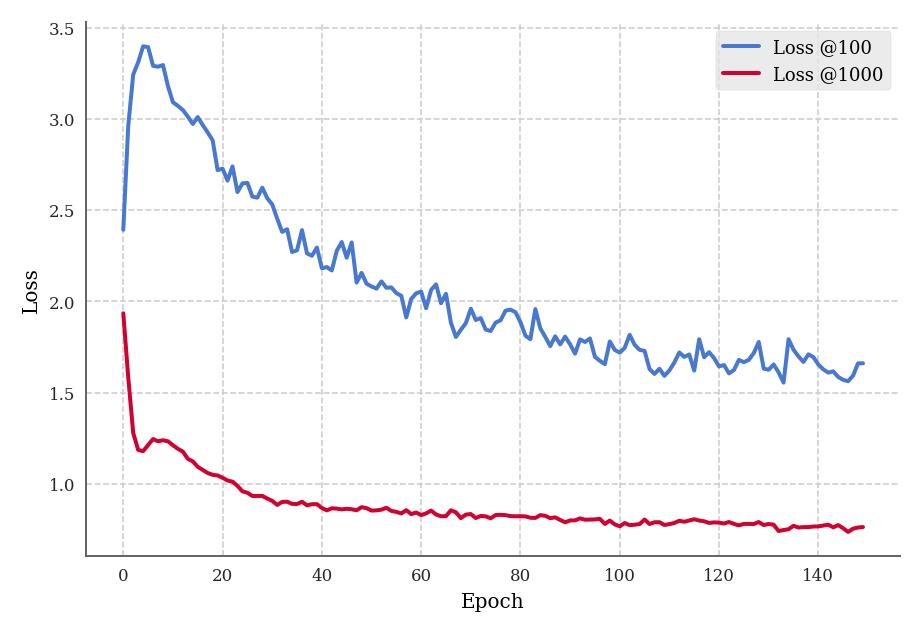

#Q7
To avoid overfitting, we used an ensemble of techniques.
We started by studying that acc/loss curve for each model traning phase, and choosing an adequate learning rate so we could arrive at the loss minimum at a reasonable speed. After achieving that minimum, the learning rate keeps decreasing so we work around in that 'plateau'.

Following the common SSL pipeline, we a also used data augmentation to medicate  our lack of labeled images, allowing us to do a more extensive traning without reapeating the same limited amount of labeled training set.

There are also some functions we can add in our net to help the process, such as the Dropout, that randomly 'zeros' some of the network's weights during training, and the Batch Regularisation, that regularizes a batch of data before/after it exits a layer. Most sources recommended Batch Regularization over Dropout Techniques for CNN models, something which we applied through our work here.

# Question for the report
I want that you send me a small report with the answer to this question and your notebook.
- Q0: Please train wideresnet, and please understand a bit wideresnet. (adding comments in the code)
- Q1: Please change DNN with a Resnet 18. Try with one that is pre-trained and one that is not pre-trained.
- Q2: Please change DNN with an AlexNet. Try with one that is pre-trained and one that is not pre-trained. (Be careful, you need a bit to play with the learning rate, for questions two, one and zeros I want to see the training loss and training accuracy. What other curb is interesting? Plot it and analyse it.)
- Q3: Please try to train an SVM and a random forest.
- Q4 After you have trained several models please draw a table and make some conclusions.
-  Q5 Read the paper fixmatch (https://amitness.com/2020/03/fixmatch-semi-supervised/) and explain it.
- Q6 please try to implement it and try to make it work.
- Q7 What can we do to avoid overfitting in Deep learning?
 (help questions 1-4: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

*Q0-Q5 = 14 pts*

*Q6 = 6 pts*

*Q7 = 1 pts*